In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

In [3]:
tf.__version__


'1.14.0'

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes= load_dataset()

y=1


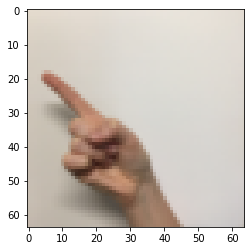

In [8]:
index = 7
plt.imshow(X_train_orig[index])
print("y="+ str(np.squeeze(Y_train_orig[:,index])))

In [9]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig,6).T
Y_test = convert_to_one_hot(Y_test_orig,6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [11]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [16]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4, 4, 3, 8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2, 2, 8, 16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [17]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 ="+ str(parameters["W1"].eval()[1,1,1]))
    print("W2 ="+ str(parameters["W2"].eval()[1,1,1]))
    

W1 =[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 =[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [18]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    
    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    
    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    
    return Z3

In [20]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3),Y:np.random.randn(2,6)})
    print("Z3 = "+str(a))

Z3 = [[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [21]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
    return cost

In [22]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.6648703


In [25]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs=400, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape 
    n_y = Y_train.shape[1]                            
    costs = []
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                if print_cost == True and epoch % 100 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 0.124256
Cost after epoch 0: 0.235755
Cost after epoch 0: 0.346379
Cost after epoch 0: 0.460018
Cost after epoch 0: 0.572946
Cost after epoch 0: 0.686253
Cost after epoch 0: 0.799503
Cost after epoch 0: 0.911139
Cost after epoch 0: 1.023798
Cost after epoch 0: 1.136514
Cost after epoch 0: 1.248791
Cost after epoch 0: 1.360714
Cost after epoch 0: 1.472453
Cost after epoch 0: 1.584704
Cost after epoch 0: 1.697069
Cost after epoch 0: 1.809473
Cost after epoch 0: 1.921332
Cost after epoch 100: 0.063386
Cost after epoch 100: 0.134865
Cost after epoch 100: 0.197491
Cost after epoch 100: 0.264899
Cost after epoch 100: 0.310054
Cost after epoch 100: 0.368994
Cost after epoch 100: 0.434706
Cost after epoch 100: 0.488158
Cost after epoch 100: 0.535704
Cost after epoch 100: 0.584803
Cost after epoch 100: 0.647215
Cost after epoch 100: 0.704818
Cost after epoch 100: 0.756478
Cost after epoch 100: 0.841117
Cost after epoch 100: 0.904832
Cost after epoch 100: 0.956068
Cost after 

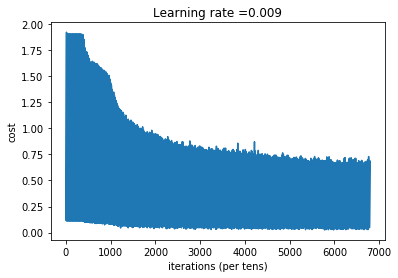

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7675926
Test Accuracy: 0.64166665


In [26]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)